## Load packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import scipy.stats as stats

In [2]:
antifungal = "Clotrimazole"
molar_mass = 344.85
date = "2023-01-19"
organism = "Candida albicans"

## Import layout

In [3]:
#source_plate = '../growth_curve_files/plate.xlsx'
source_plate = r"plan_clotri_prise1_CB.xlsx"
plate_df = pd.read_excel(source_plate, header=0, index_col=0)
plate_df.head(3)

,strain,conc
well,,
A1,ERG11-DOX C.a,0.025
B1,ERG11-DOX C.a,0.025
C1,ERG11-DOX C.a,0.550


In [4]:
#importation of excel output from the TECAN
source_table1 = r"clotrimazole_OD_2022.xlsx"
source_df = pd.read_excel(source_table1, header=0, index_col=0)
source_df.head()

,0,900,1800,2700,3600,4501,5401,6301,7201,8101,...,163821,164722,165622,166522,167422,168322,169222,170122,171022,171923
A1,0.12912,0.12925,0.12922,0.12945,0.12937,0.12955,0.12993,0.13003,0.13033,0.13038,...,1.10990,1.11050,1.11050,1.11070,1.11090,1.11170,1.11150,1.11120,1.11090,1.11160
B1,0.13320,0.13250,0.13240,0.13230,0.13243,0.13255,0.13262,0.13278,0.13327,0.13333,...,1.11990,1.11920,1.12080,1.12080,1.12170,1.12140,1.12140,1.12140,1.12210,1.12190
C1,0.13115,0.13078,0.13072,0.13058,0.13067,0.13058,0.13105,0.13105,0.13135,0.13165,...,0.80395,0.80485,0.80615,0.80637,0.80658,0.80827,0.80835,0.80907,0.80902,0.81000
D1,0.13212,0.13103,0.13065,0.13050,0.13033,0.13048,0.13042,0.13062,0.13080,0.13085,...,0.81675,0.81823,0.81903,0.81985,0.82072,0.82140,0.82260,0.82355,0.82322,0.82402
A2,0.12960,0.12967,0.12965,0.12983,0.12987,0.13005,0.13018,0.13035,0.13100,0.13093,...,1.11690,1.11750,1.11770,1.11800,1.11820,1.11860,1.11910,1.11850,1.11870,1.11900


In [5]:
#conversion of timepoints (s) -> (h)
rename_dict = {}

for col_name in source_df.columns:
    to_hours = np.float64(col_name)/(60*60)
    rename_dict[col_name] = to_hours
    
source_df.rename(columns = rename_dict, inplace=True)

source_df.head()

,0.000000,0.250000,0.500000,0.750000,1.000000,1.250278,1.500278,1.750278,2.000278,2.250278,...,45.505833,45.756111,46.006111,46.256111,46.506111,46.756111,47.006111,47.256111,47.506111,47.756389
A1,0.12912,0.12925,0.12922,0.12945,0.12937,0.12955,0.12993,0.13003,0.13033,0.13038,...,1.10990,1.11050,1.11050,1.11070,1.11090,1.11170,1.11150,1.11120,1.11090,1.11160
B1,0.13320,0.13250,0.13240,0.13230,0.13243,0.13255,0.13262,0.13278,0.13327,0.13333,...,1.11990,1.11920,1.12080,1.12080,1.12170,1.12140,1.12140,1.12140,1.12210,1.12190
C1,0.13115,0.13078,0.13072,0.13058,0.13067,0.13058,0.13105,0.13105,0.13135,0.13165,...,0.80395,0.80485,0.80615,0.80637,0.80658,0.80827,0.80835,0.80907,0.80902,0.81000
D1,0.13212,0.13103,0.13065,0.13050,0.13033,0.13048,0.13042,0.13062,0.13080,0.13085,...,0.81675,0.81823,0.81903,0.81985,0.82072,0.82140,0.82260,0.82355,0.82322,0.82402
A2,0.12960,0.12967,0.12965,0.12983,0.12987,0.13005,0.13018,0.13035,0.13100,0.13093,...,1.11690,1.11750,1.11770,1.11800,1.11820,1.11860,1.11910,1.11850,1.11870,1.11900


## Reshape (wide to long)

In [6]:
longdf = source_df.reset_index().rename(columns = {'index' : 'well'})
longdf = longdf.melt(id_vars = ['well'], var_name = 'time (h)', value_name = 'OD')
longdf

,well,time (h),OD
0,A1,0.0,0.12912
1,B1,0.0,0.13320
2,C1,0.0,0.13115
3,D1,0.0,0.13212
4,A2,0.0,0.12960
...,...,...,...
7291,B11,47.756389,0.94343
7292,A12,47.756389,0.71305
7293,B12,47.756389,0.77025
7294,G1,47.756389,1.18430


## Annotate dataframe with layout

In [7]:
merged_df = longdf.merge(right=plate_df, on=['well'])
merged_df.head(5)

,well,time (h),OD,strain,conc
0,A1,0.0,0.12912,ERG11-DOX C.a,0.025
1,A1,0.25,0.12925,ERG11-DOX C.a,0.025
2,A1,0.5,0.12922,ERG11-DOX C.a,0.025
3,A1,0.75,0.12945,ERG11-DOX C.a,0.025
4,A1,1.0,0.12937,ERG11-DOX C.a,0.025


## Visualization (example)

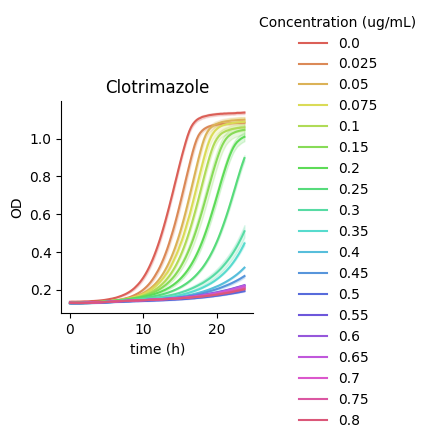

In [8]:
grid = sns.FacetGrid(data=merged_df[merged_df['time (h)'] <=24], hue='conc', palette='hls')
grid.map(sns.lineplot, 'time (h)', 'OD')
#grid.set_titles(col_template='{col_name}')
grid.set_axis_labels('time (h)', 'OD')
grid.add_legend(title = 'Concentration (ug/mL)')
grid.fig.subplots_adjust(top=0.9)
plt.title(antifungal)
axes = grid.axes.flatten()
title = "GC_" + antifungal + "_" + organism + "_" + date
plt.savefig(title, format='png', dpi=300)
#plt.savefig('../growth_curve_files/graphs/mica_40h.png', format='png', dpi=300)

## Calculate area under the curve (AUC)

In [9]:
def get_auc(g):
    return np.trapz(g.OD)

In [10]:
aucdf = merged_df[merged_df['time (h)'] <= 24].groupby('well')[['OD']].apply(func=get_auc).reset_index(name='auc')
condensed_df = plate_df.merge(right=aucdf, on=['well'])
condensed_df.head(3)

,well,strain,conc,auc
0,A1,ERG11-DOX C.a,0.025,47.802880
1,B1,ERG11-DOX C.a,0.025,49.438160
2,C1,ERG11-DOX C.a,0.550,15.193295


## Calculate derivative growth rate (DGR)

In [11]:
def get_derivative_growth_rate(g):
    # rate is multiplied by 4 to convert from /15min (measurements every 15 min) to /h
    data_diff = g.OD.diff()*4
    get_top_5 = data_diff.nlargest(5)    
    growth_rate = np.median(get_top_5)
    return growth_rate

In [12]:
dgr = merged_df[merged_df['time (h)'] <= 24].groupby('well')[['OD']].apply(func=get_derivative_growth_rate).reset_index(name='dgr')
condensed_df = plate_df.merge(right=dgr, on=['well'])
condensed_df.head(3)

,well,strain,conc,dgr
0,A1,ERG11-DOX C.a,0.025,0.1606
1,B1,ERG11-DOX C.a,0.025,0.1598
2,C1,ERG11-DOX C.a,0.550,0.0116


## Convert concentrations (ug/mL -> uM)

In [13]:
def convert_to_uM(ug, mass_mol):
    # a simple function to convert ug/ml to uM with the molecular weigth of the compound
    vol = 0.001
    uM = (((ug*10**-6)/(vol*mass_mol))*10**6)
    return uM

In [14]:

condensed_df['concentration_uM'] = condensed_df['conc'].apply(lambda x: convert_to_uM(x, molar_mass))
condensed_df

,well,strain,conc,dgr,concentration_uM
0,A1,ERG11-DOX C.a,0.025,0.16060,0.072495
1,B1,ERG11-DOX C.a,0.025,0.15980,0.072495
2,C1,ERG11-DOX C.a,0.550,0.01160,1.594896
3,D1,ERG11-DOX C.a,0.550,0.01084,1.594896
4,A2,ERG11-DOX C.a,0.050,0.16400,0.144991
5,B2,ERG11-DOX C.a,0.050,0.16344,0.144991
6,C2,ERG11-DOX C.a,0.600,0.01200,1.739887
7,D2,ERG11-DOX C.a,0.600,0.00948,1.739887
8,A3,ERG11-DOX C.a,0.075,0.15180,0.217486
9,B3,ERG11-DOX C.a,0.075,0.15940,0.217486


## Convert concentrations (uM -> ug/mL)

In [15]:
def convert_to_ug(uM, mass_mol):
    # a simple function to convert uM to ug/ml with the molecular weigth of the compound
    ug = (uM*mass_mol)/1000
    return ug

## Calculate inhibition coefficient

In [16]:
# Setting the value to be used to calculate the inhibition coefficient
# Either derivative growth rate (fitness_type = 'dgr')
# or normalized AUC parameter (fitness_type = 'norm_auc')
if 'dgr' in condensed_df.columns.tolist():
    fitness_type = 'dgr'
elif 'auc' in condensed_df.columns.tolist():
    fitness_type = 'norm_auc'
else:
    print('Fitness has not been calculated')

In [17]:
def get_inhib_coeff(df, fitness, fitness_type):
    # Inhibition coefficient is calculated either from the derivative growth rate (fitness_type = 'dgr')
    # or the normalized AUC parameter (fitness_type = 'norm_auc')
    ref = df.loc[(df.concentration_uM==0), 'dgr'].mean()
    return (ref - fitness)/ref

In [18]:
condensed_df['inhib_coeff'] = condensed_df['dgr'].apply(lambda x: get_inhib_coeff(condensed_df, x, 'dgr'))
condensed_df.head(3)

,well,strain,conc,dgr,concentration_uM,inhib_coeff
0,A1,ERG11-DOX C.a,0.025,0.1606,0.072495,-0.019683
1,B1,ERG11-DOX C.a,0.025,0.1598,0.072495,-0.014603
2,C1,ERG11-DOX C.a,0.550,0.0116,1.594896,0.926349


## Hill equation + fitting

In [19]:
#fit_data = condensed_df[(condensed_df.strain=='LL13-040') & (condensed_df.genotype=='WT') & (condensed_df.concentration_uM!=0) & (condensed_df.concentration_uM<50)][['concentration_uM','replicate','inhib_coeff']]
fit_data = condensed_df[(condensed_df.concentration_uM!=0)].groupby(['concentration_uM'])[['inhib_coeff']].mean().reset_index()
fit_data

,concentration_uM,inhib_coeff
0,0.072495,-0.017143
1,0.144991,-0.039492
2,0.217486,0.012063
3,0.289981,0.040254
4,0.434972,0.102603
5,0.579962,0.159238
6,0.724953,0.176508
7,0.869943,0.513270
8,1.014934,0.566984
9,1.159925,0.781333


In [20]:
wt_conc = fit_data.concentration_uM.values
wt_inhib = fit_data.inhib_coeff.values

In [21]:
print(wt_conc)
print(wt_inhib)

[0.07249529 0.14499058 0.21748586 0.28998115 0.43497173 0.5799623
 0.72495288 0.86994345 1.01493403 1.1599246  1.30491518 1.44990576
 1.59489633 1.73988691 1.88487748 2.02986806 2.17485863 2.31984921]
[-0.01714286 -0.03949206  0.01206349  0.04025397  0.10260317  0.1592381
  0.17650794  0.51326984  0.56698413  0.78133333  0.85790476  0.95263492
  0.9287619   0.93180952  0.92520635  0.93193651  0.93955556  0.94260317]


In [22]:
def hill_equation(x, E, n):
    # this function defines the hill equation, where:
    # x is the drug concentration
    # E is the concentration with half effect (IC50)
    # n is the hill coefficient,
    
    return 1/(1+((E/x)**n))

In [23]:
import scipy as sci

# Get best fit parameters (popt) and covariance matrix (pcov)
popt, pcov = sci.optimize.curve_fit(hill_equation, wt_conc, wt_inhib, p0=[0.25,5])
print(popt)
print(pcov)

[0.90629815 4.46536592]
[[0.00041646 0.00190365]
 [0.00190365 0.14742533]]


In [24]:
def get_IC(v, E, n):
    # This function calculates ICv based on IC50 (E) and hill coefficient (n) for any v value between 0 and 1
    return E*((v/(1-v))**(1/n))

In [25]:
ic50_mol = round(get_IC(0.5,popt[0],popt[1]),2)
#This value should be equal to popt[0]
print('IC50 = {} uM'.format(ic50_mol))
ic75_mol = round(get_IC(0.75,popt[0],popt[1]),2)
print('IC75 = {} uM'.format(ic75_mol))

IC50 = 0.91 uM
IC75 = 1.16 uM


In [26]:
def convert_to_ug(uM, mass_mol):
    # a simple function to convert uM to ug/ml with the molecular weigth of the compound
    ug = (uM*mass_mol)/1000
    return ug

In [27]:
ic50 = convert_to_ug(ic50_mol, molar_mass)
ic50

0.3138135

In [28]:
dof = np.size(wt_inhib) - 1 # degrees of freedom:
# calculate student-t value
a = 0.05 #(1-0.95, 95% CI)
tval = stats.t.ppf(1.0-a/2, dof)
ci_cy = tval*np.sqrt(pcov)[0]
# this little snippet of code allows to calculate the 95% confidence interval on both parameters.
# based on this, we would have IC50 = 9.26 uM +/- 1.18 and hill_coeff = 0.749 +/- 0.019

ci_cy

array([0.043056  , 0.09205303])

In [29]:
interval = convert_to_ug(ci_cy[0], molar_mass)
interval

0.01484786058785853

In [30]:
# now we'll want to plot our curve on top of the data. However, since we'll be plotting on both linear and log
# axis, we need to choose x coordinates across our range of concentrations that are not log-distributed and not 
# linearly distributed
fit_vals = np.logspace(np.log2(wt_conc.min()),np.log2(wt_conc.max()), num=50, base=2)

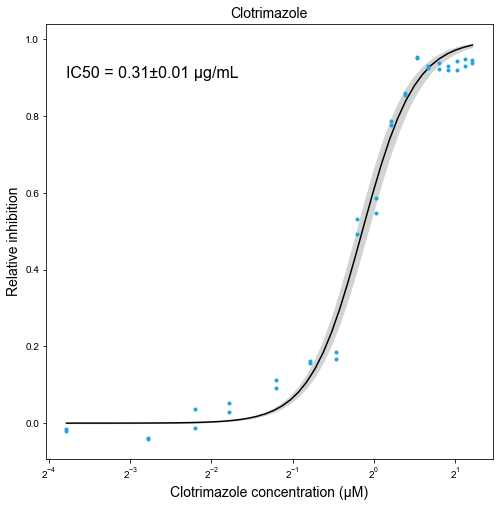

In [32]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(8,8))


plt.plot(condensed_df['concentration_uM'],condensed_df['inhib_coeff'], color='#1DA3DE', 
         marker='o', ms=3, linestyle='None', zorder=9)

plt.plot(fit_vals, [hill_equation(x,popt[0], popt[1]) for x in fit_vals], 'k')


plt.fill_between(fit_vals, [hill_equation(x,popt[0]+ci_cy[0], popt[1]-ci_cy[1]) for x in fit_vals],
                 [hill_equation(x,popt[0]-ci_cy[0], popt[1]+ci_cy[1]) for x in fit_vals], color='lightgrey')

plt.xscale('log',base=2)

text = "IC50 = " + str(round(ic50,2)) + "\u00B1" + str(round(interval,2)) +" μg/mL"
#text = "\nou " + str(round(ic50_mol,2)) + "\u00B1" + str(round(ci_cy[0],2)) + " $\mu$M\n" + "\nCoefficient de Hill = " + str(round(popt[1],2)) + "\u00B1" + str(round(ci_cy[1],2))+ "\n\nBasé sur le\ntaux de croissance dérivé\naprès 24h"
plt.text(wt_conc.min(), 0.9, text, fontsize=16) 

plt.xlabel(antifungal + " concentration (μM)", fontsize=14)
plt.ylabel('Relative inhibition', fontsize=14)
plt.title(antifungal, fontsize=14)

plt.rcParams['svg.fonttype'] = 'none'
name = "Dose-response_curve_" + antifungal + "_"+ organism + "24H" + "_" + date
plt.savefig(f"c:{name}.png", format='png', dpi=300)
plt.savefig(f"c:{name}.svg", format='svg', dpi=300)